In [1]:
import geopandas as gpd

In [2]:
gdf = gpd.read_file("all_states_precincts_cname_neighbor_demo_OG_anomalous.json")

In [3]:
gdf.head(1)

,County,Precinct #,Hillary Clinton/Dem,Donald J. Trump/Rep,Gary Johnson/Lib,Jill Stein/Grn,Other/Other,Total Votes,State,CName,...,Total Population,White,Black or African American,American Indian,Asian,Other Population,MissingVote,MissingDemo,VoteDemoConflict,geometry
0,Bristol,0101,1027,522,60,23,2,1634,ri,ri-bristol-0101,...,3268,3055,23,3,110,73,None,None,None,"POLYGON ((-71.32270 41.77270, -71.32270 41.772..."


In [4]:
c = list(gdf.columns)
c.remove("CName")
c.remove("State")
c.remove("geometry")
c.remove("Neighbors")
gdf.drop(columns=c, inplace=True, axis=1)

In [5]:
copy = gdf.copy()

# 15. Identify overlapping precincts (required) (sequence diagram not required)
- Identify pairs of precincts for which one or more edges of one precinct intersect with edges of the
other precinct. 
- Do not identify abutting edges where the edges represent a common border between the precincts. 
- Precinct edges of adjacent precincts are considered coincident if they are within 200 feet. 
- Store the associated data in the errors data structure for subsequent addition to the DB.
- .to_crs("EPSG:3857") meters
- .to_crs("EPSG:4326") real world
- 60.96 meters = 200 feet

In [20]:
ri = gdf[gdf["State"] == "ri"]
va = gdf[gdf["State"] == "va"]
tx = gdf[gdf["State"] == "tx"]

In [21]:
gdfMap = {}

def checkRepeat(gdf, CName1, CName2):
    cname1GDF = gdf[gdf["CName1"] == CName1]
    bothGDF = cname1GDF[cname1GDF["CName2"] == CName2]
    if len(bothGDF):
        return True
    else:
        return False

def detectOverlap(gdf, ID):
    print("\nStarting", ID)
    
    gdf_shrink = gdf.to_crs("EPSG:3857")
    gdf_shrink["shrink"] = gdf_shrink["geometry"].buffer(-30.48) # shrink by 100 feet
    gdf_shrink.set_geometry("shrink", drop=True, inplace=True)
    gdf_shrink = gdf_shrink.to_crs("EPSG:4326")
    
    # create new gdf
    newgdf = gpd.GeoDataFrame(columns=["CName1", "CName2", "OverlappingRegion"])
    newgdf.set_geometry("OverlappingRegion", inplace=True)
    
    # detect overlap based on neighbors
    # only keep cnames, and find overlap region with unshrinked gdf
    for index, row in gdf_shrink.iterrows():
        if row["Neighbors"] != "":
            cur_geometry = row["geometry"]
            neighbors = row["Neighbors"].split(";")
            neighbors = [n.strip().split(",")[1] for n in neighbors]

            for n in neighbors:
                cur_neighbor = gdf.at[gdf[gdf["CName"] == n].index.to_list()[0], "geometry"]
                # check if interesect
                if cur_geometry.intersects(cur_neighbor) and not checkRepeat(newgdf, row["CName"], n):
                    newgdf = newgdf.append({"CName1": row["CName"], "CName2": n, "OverlappingRegion": ""}, ignore_index=True)
                    print("#", end="")
                    
    # fill in overlapping region
    for index, row in newgdf.iterrows():
        poly1 = gdf.at[gdf[gdf["CName"] == row["CName1"]].index.to_list()[0], "geometry"]
        poly2 = gdf.at[gdf[gdf["CName"] == row["CName2"]].index.to_list()[0], "geometry"]
        
        # intersection
        overlappingRegion = poly1.intersection(poly2)
        newgdf.at[index, "OverlappingRegion"] = overlappingRegion
        
                
    gdfMap[ID] = newgdf

In [67]:
detectOverlap(ri, "ri")


Starting ri


In [22]:
detectOverlap(va, "va")


Starting va
############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [69]:
detectOverlap(tx, "tx")


Starting tx


In [23]:
gdfMap["va"].head()

,CName1,CName2,OverlappingRegion
0,va-albemarle-0021,va-charlottesvillecity-0354,(POLYGON ((-78.46687719188455 38.0678170661552...
1,va-albemarle-0022,va-augusta-0169,(POLYGON ((-78.83475472557971 38.0500266186691...
2,va-albemarle-0022,va-nelson-1504,POLYGON ((-78.80658482041333 37.99216843425849...
3,va-albemarle-0023,va-charlottesvillecity-0347,(POLYGON ((-78.50560724653202 38.0103808583571...
4,va-albemarle-0025,va-rockingham-2049,(POLYGON ((-78.74943338471822 38.2065889869396...


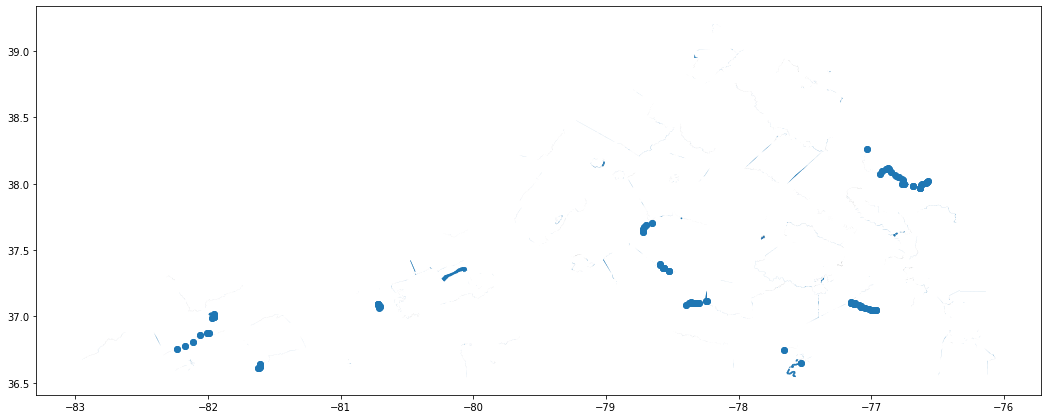

In [24]:
gdfMap["va"].plot(figsize=(18, 13))

In [26]:
vaOverlap = gdfMap["va"]

In [29]:
i = 0
vaOverlap["ID"] = ""
for index, row in vaOverlap.iterrows():
    vaOverlap.at[index, "ID"] = "va-overlap-" + str(i)
    i += 1
vaOverlap.head(2)

,CName1,CName2,OverlappingRegion,ID
0,va-albemarle-0021,va-charlottesvillecity-0354,(POLYGON ((-78.46687719188455 38.0678170661552...,va-overlap-0
1,va-albemarle-0022,va-augusta-0169,(POLYGON ((-78.83475472557971 38.0500266186691...,va-overlap-1


In [30]:
vaOverlap.to_file("VA_Overlap.json", driver="GeoJSON")